In [ ]:
!pip install dask[dataframe]


INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 5.0 MB/s eta 0:00:00


In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 5.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import os
from tqdm import tqdm
import torch
import emoji
from transformers import pipeline, AutoTokenizer
from transformers import BertTokenizer, BertModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Training**

## **Training Dataset**

In [ ]:
reddit_dir = '/content/drive/MyDrive/KHP_Data/Scraped_Reddit/'

df_anxiety_all = pd.read_csv(os.path.join(reddit_dir, 'top_Anxiety.csv'))
df_socialanxiety = pd.read_csv(os.path.join(reddit_dir, 'top_socialanxiety.csv'))
df_depression = pd.read_csv(os.path.join(reddit_dir, 'top_depression.csv'))
df_happy = pd.read_csv(os.path.join(reddit_dir, 'top_happy.csv'))
df_positivity = pd.read_csv(os.path.join(reddit_dir, 'top_Positivity.csv'))
df_wholesomememes = pd.read_csv(os.path.join(reddit_dir, 'top_wholesomememes.csv'))

In [ ]:
df_anxiety = pd.concat([df_anxiety_all, df_socialanxiety, df_depression], ignore_index=True)
df_non_anxiety = pd.concat([df_happy, df_positivity, df_wholesomememes], ignore_index=True)

print('number of anxiety posts: ',len(df_anxiety))
print('number of non-anxiety posts: ',len(df_non_anxiety))

number of anxiety posts:  2963
number of non-anxiety posts:  2953


In [ ]:
df_anxiety.columns

Index(['date', 'title', 'score', 'content', 'comment_1_body',
       'comment_1_score', 'comment_2_body', 'comment_2_score',
       'comment_3_body', 'comment_3_score', 'comment_4_body',
       'comment_4_score', 'comment_5_body', 'comment_5_score',
       'comment_6_body', 'comment_6_score', 'comment_7_body',
       'comment_7_score', 'comment_8_body', 'comment_8_score',
       'comment_9_body', 'comment_9_score', 'comment_10_body',
       'comment_10_score', 'comment_11_body', 'comment_11_score',
       'comment_12_body', 'comment_12_score', 'comment_13_body',
       'comment_13_score', 'comment_14_body', 'comment_14_score',
       'comment_15_body', 'comment_15_score', 'comment_16_body',
       'comment_16_score', 'comment_17_body', 'comment_17_score',
       'comment_18_body', 'comment_18_score', 'comment_19_body',
       'comment_19_score', 'comment_20_body', 'comment_20_score'],
      dtype='object')

#### **Data Preprocessing**
- Remove any occurrences of [deleted], [removed], links, and subreddit names from the posts.
- Structure the DataFrame with separate rows for each of the following:
  - post titles
  - post content
  - comments

In [ ]:
def preprocess_data(df):
    def clean_text(text):
      if pd.isna(text):
          return ''
      if isinstance(text, str):
          text = text.replace('[deleted]', '').replace('[removed]', '') #replace [deleted] and [removed] with an empty string
          text = re.sub(r'https?://\S+', '', text) #replace links with an empty string
          text = re.sub(r'r/\S+', '', text) #replace subreddits with an empty string
          #text = emoji.demojize(text, delimiters=(" ", " "))
          return text.strip()
      return str(text)

    text_columns = ['title', 'content'] + [f'comment_{i}_body' for i in range(1, 11)]

    for col in text_columns:
        df[col] = df[col].apply(clean_text)

    # Extract text examples from the DataFrame
    text_examples = [
        text for row in df[text_columns].itertuples(index=False)
        for text in row if pd.notna(text) and text != ''
    ]

    df = pd.DataFrame({'text': text_examples})

    return df

In [ ]:
df_anxiety = preprocess_data(df_anxiety)
df_non_anxiety = preprocess_data(df_non_anxiety)

print('number of anxiety texts (posts/comments): ',len(df_anxiety))
print('number of non-anxiety texts (posts/comments): ',len(df_non_anxiety))

number of anxiety texts (posts/comments):  32635
number of non-anxiety texts (posts/comments):  26149


In [ ]:
df_anxiety.head()

,text
0,"Despite the anxiety, despite the depression, d..."
1,Nice to see people not getting stopped by thei...
2,Nawww congratulations!...you look absolutely s...
3,Glowing!!! Congrats and you look great!!! 💛💛💛
4,"You look beautiful, happy, and confident! Cong..."


#### **Sentiment Analysis**

In [ ]:
# Load a pre-trained sentiment analysis model
model_name = 'finiteautomata/bertweet-base-sentiment-analysis'
sentiment_analyzer = pipeline("text-classification", model=model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

In [ ]:
def sentiment_analysis(df, batch_size=128):
    if 'text' not in df.columns:
        raise ValueError("DataFrame must contain a 'text' column")

    texts = df['text'].tolist()
    label = []
    confidence = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        results = sentiment_analyzer(batch, truncation=True, padding=True)

        for result in results:
            label.append(result['label'])
            confidence.append(result['score'])

    df['sentiment_label'] = label
    df['sentiment_confidence'] = confidence
    return df

In [ ]:
df_anxiety_sentiment = sentiment_analysis(df_anxiety)


100%|██████████| 255/255 [1:58:09<00:00, 27.80s/it]


In [ ]:
df_anxiety_sentiment['sentiment_label'].value_counts()

,count
sentiment_label,
NEG,15182
NEU,9192
POS,8261


In [ ]:
df_anxiety_sentiment['sentiment_label'].value_counts()/len(df_anxiety_sentiment)

,count
sentiment_label,
NEG,0.465206
NEU,0.281661
POS,0.253133


The sentiments of posts and comments in anxiety-related subreddits are:

- 47% negative (15182 text examples)
- 28% neutral
- 25% positive

In [ ]:
df_anxiety_sentiment.sample(n=10)

,text,sentiment_label,sentiment_confidence
3161,People think I’m crazy because I like to work....,NEG,0.523386
12757,"Ha, I have a doctors appointment I am waiting ...",NEU,0.884261
17800,This is why it’s the middle of the day on a Su...,NEG,0.633847
1619,I’m sorry you’re struggling. If you feel reall...,NEU,0.569116
411,I love it! I wish I could do something like this,POS,0.992749
15705,"TBH, I manage to blow it even when I force mys...",NEG,0.742988
14969,Everytime dammit..,NEG,0.789085
9450,"Cognitive behavioral, EMDR, what kind of thera...",NEU,0.923041
24473,Can you imagine wake up in a hospital and mill...,NEG,0.922269
19170,working at home/online school luxury,NEU,0.683868


In [ ]:
df_anxiety_sentiment.to_csv('/content/drive/MyDrive/KHP_Data/Anxiety_Subreddit_Sentiment.csv', index=False)

In [ ]:
df_non_anxiety_sentiment = sentiment_analysis(df_non_anxiety)

100%|██████████| 205/205 [1:04:59<00:00, 19.02s/it]


In [ ]:
df_non_anxiety_sentiment['sentiment_label'].value_counts()

,count
sentiment_label,
POS,16672
NEU,6139
NEG,3338


In [ ]:
df_non_anxiety_sentiment['sentiment_label'].value_counts()/len(df_non_anxiety_sentiment)

,count
sentiment_label,
POS,0.637577
NEU,0.234770
NEG,0.127653


The sentiments of posts and comments in non-anxiety-related subreddits are:

- 64% positive (16672 text examples)
- 23% neutral
- 13% positive

In [ ]:
df_non_anxiety_sentiment.sample(n=10)

,text,sentiment_label,sentiment_confidence
21229,"Me scrolling through the comments section, mak...",NEU,0.854965
14265,Thank you for these kind words :),POS,0.991861
8896,That's amazing! I'm happy for you!,POS,0.992531
25667,Can't remember the last time I held actual cas...,NEU,0.803093
21860,Thanks for sharing this. I got rejected from a...,POS,0.891797
25031,Respect+,NEU,0.907983
18582,Me being 18 but 5'6 so I can still get kids pr...,NEU,0.919839
18608,Chuckie’s dad from Rugrats,NEU,0.820994
20579,"Well now I feel lonely. \n\nThen again, I’m to...",NEG,0.969600
4572,I’m not shy and am always happy to take on que...,POS,0.958466


In [ ]:
df_non_anxiety_sentiment.to_csv('/content/drive/MyDrive/KHP_Data/Non_Anxiety_Subreddit_Sentiment.csv', index=False)

#### **Data Labeling**

- Texts in anxiety subreddits with negative sentiment are lebeled as **anxiety_label=1**
- Texts in non-anxiety subreddits with positive sentiment are labeled as **anxiety_label=0**

In [ ]:
df_anxiety_labeled = df_anxiety_sentiment[(df_anxiety_sentiment['sentiment_label']=="NEG") & (df_anxiety_sentiment['sentiment_confidence'] >= 0.5)]
df_anxiety_labeled = df_anxiety_labeled.assign(anxiety_label=1)
df_anxiety_labeled = df_anxiety_labeled[['text','anxiety_label']]
print('number of anxiety texts: ',len(df_anxiety_labeled))

df_non_anxiety_labeled = df_non_anxiety_sentiment[(df_non_anxiety_sentiment['sentiment_label']=="POS") & (df_non_anxiety_sentiment['sentiment_confidence'] >= 0.5)]
df_non_anxiety_labeled = df_non_anxiety_labeled.assign(anxiety_label=0)
df_non_anxiety_labeled = df_non_anxiety_labeled[['text','anxiety_label']]
print('number of non-anxiety texts: ',len(df_non_anxiety_labeled))

number of anxiety texts:  14965
number of non-anxiety texts:  16566


In [ ]:
df_labeled = pd.concat([df_anxiety_labeled, df_non_anxiety_labeled], ignore_index=True).sample(frac=1)
print('number of data: ',len(df_labeled))

number of data:  31531


In [ ]:
df_labeled = df_labeled.sample(frac=1).reset_index(drop=True)

In [ ]:
df_labeled.head(n=5)

,text,anxiety_label
0,I remember I had a whole panic attack before m...,1
1,Fantastic smile you have!,0
2,My boyfriend's family accepted my children and...,0
3,I'm with you on this. I used to want to go int...,1
4,I've never heard of a therapist saying someone...,1


## **TF-IDF Embedding**

In [ ]:
texts = df_labeled['text']
labels = df_labeled['anxiety_label'].values

X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, stratify=labels, random_state=42)

# Feature extraction
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
len(X_train_tfidf.toarray())

25224

#### **Classification with TF-IDF Embedding**

When the dataset is imbalanced, the ROC AUC score is a better metric because it accounts for both TPR and FPR, providing a better measure of how well the model distinguishes between classes.

In [ ]:
models = [
    MultinomialNB(),
    LogisticRegression(max_iter=1000, random_state=42),
    SVC(kernel='linear', random_state=42),
    RandomForestClassifier(n_estimators=100, random_state=42),
    XGBClassifier(eval_metric='logloss', random_state=42),
    LGBMClassifier(verbose=-1, random_state=42),
]
scoring_metrics = {
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc'
}

for model in models:
    scores = cross_validate(model, X_train_tfidf, y_train, cv=5, scoring=scoring_metrics, return_train_score=False)

    mean_accuracy = np.mean(scores['test_accuracy'])
    std_accuracy = np.std(scores['test_accuracy'])
    mean_roc_auc = np.mean(scores['test_roc_auc'])
    std_roc_auc = np.std(scores['test_roc_auc'])

    # Print results
    print(model.__class__.__name__)
    print(f"Accuracy = {mean_accuracy:.3f} (+/- {std_accuracy * 2:.3f})")
    print(f"ROC AUC = {mean_roc_auc:.3f} (+/- {std_roc_auc * 2:.3f})")
    print('\n')


MultinomialNB
Accuracy = 0.929 (+/- 0.004)
ROC AUC = 0.983 (+/- 0.002)


LogisticRegression
Accuracy = 0.930 (+/- 0.003)
ROC AUC = 0.982 (+/- 0.002)


SVC
Accuracy = 0.938 (+/- 0.003)
ROC AUC = 0.984 (+/- 0.001)


RandomForestClassifier
Accuracy = 0.886 (+/- 0.006)
ROC AUC = 0.956 (+/- 0.003)


XGBClassifier
Accuracy = 0.903 (+/- 0.006)
ROC AUC = 0.969 (+/- 0.001)


LGBMClassifier
Accuracy = 0.913 (+/- 0.006)
ROC AUC = 0.974 (+/- 0.002)




#### **Saving Anxiety Classifier**
SVC classifier has the best accuracy and ROC AUC on cross-validation dataset.

In [ ]:
svc = SVC(kernel='linear', random_state=42)
svc.fit(X_train_tfidf, y_train)
svc_pred = svc.predict(X_test_tfidf)
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3314
           1       0.94      0.94      0.94      2993

    accuracy                           0.94      6307
   macro avg       0.94      0.94      0.94      6307
weighted avg       0.94      0.94      0.94      6307



In [ ]:
model_filename = '/content/drive/MyDrive/KHP_Data/Anxiety_Classifier_TFIDF_Embedding.joblib'
joblib.dump(svc, model_filename)

['/content/drive/MyDrive/KHP_Data/Anxiety_Classifier_TFIDF_Embedding.joblib']

# **Predicting**

## **Climate Dataset**

In [ ]:
reddit_dir = '/content/drive/MyDrive/KHP_Data/Scraped_Reddit/'

df_ClimateOffensive = pd.read_csv(os.path.join(reddit_dir, 'top_ClimateOffensive.csv'))
df_climatechange = pd.read_csv(os.path.join(reddit_dir, 'top_climatechange.csv'))
df_sustainability = pd.read_csv(os.path.join(reddit_dir, 'top_sustainability.csv'))

In [ ]:
df_climate = pd.concat([df_ClimateOffensive, df_climatechange, df_sustainability], ignore_index=True)
print('number of climate posts: ',len(df_climate))

number of climate posts:  2996


#### **Data Preprocessing**

In [ ]:
def preprocess_data(df):
    def clean_text(text):
        if pd.isna(text):
            return ''
        if isinstance(text, str):
            text = text.replace('[deleted]', '').replace('[removed]', '') #replace [deleted] and [removed] with an empty string
            text = re.sub(r'https?://\S+', '', text) #replace links with an empty string
            text = re.sub(r'r/\S+', '', text) #replace subreddits with an empty string
            return text.strip()
        return str(text)

    text_columns = ['title', 'content'] + [f'comment_{i}_body' for i in range(1, 20)]

    for col in text_columns:
        df[col] = df[col].apply(clean_text)

    text_examples = [
        text for row in df[text_columns].itertuples(index=False)
        for text in row if pd.notna(text) and text != ''
    ]

    return pd.DataFrame({'text': text_examples})

In [ ]:
df_climate = preprocess_data(df_climate)

In [ ]:
print('number of climate texts (posts/comments): ',len(df_climate))

number of climate texts (posts/comments):  31943


In [ ]:
df_climate.head()

,text
0,We’re doing EXACY:Y what Greta told us not to do.
1,"Not exactly related to the Climate Crisis, but..."
2,"Whether you're an adult or not, you can [lobby..."
3,It’s 3:48 am and all I can think is I gotta wa...
4,Worth noting that Person of the Year isn't rea...


#### **Data Embedding**

In [ ]:
climate_texts = df_climate['text']
# Feature extraction
vectorizer = TfidfVectorizer(max_features=5000)
climate_texts_tfidf = vectorizer.fit_transform(climate_texts)

In [ ]:
len(climate_texts_tfidf.toarray())

31943

#### **Loading Saved Model**

In [ ]:
model_filename = '/content/drive/MyDrive/KHP_Data/Anxiety_Classifier_TFIDF_Embedding.joblib'
loaded_model = joblib.load(model_filename)

#### **Predicting Anxiety/Non Anxiety posts**

In [ ]:
predictions = loaded_model.predict(climate_texts_tfidf)
df_climate = df_climate.assign(anxiety_label=predictions)

df_climate.head()

,text,anxiety_label
0,We’re doing EXACY:Y what Greta told us not to do.,0
1,"Not exactly related to the Climate Crisis, but...",0
2,"Whether you're an adult or not, you can [lobby...",0
3,It’s 3:48 am and all I can think is I gotta wa...,0
4,Worth noting that Person of the Year isn't rea...,0


In [ ]:
df_climate['anxiety_label'].value_counts()

,count
anxiety_label,
0,23883
1,8060


In [ ]:
df_climate['anxiety_label'].value_counts()/len(df_climate)

,count
anxiety_label,
0,0.747676
1,0.252324


- ***25%*** of posts/comments in climate related subreddits indicate anxiety.

#### **Merging Anxiety and Youth Labels**

In [ ]:
climate_youth_labeled = pd.read_csv('/content/drive/MyDrive/KHP_Data/Climate_Labelled.csv')
climate_youth_labeled.head()

,text,youth_label
0,We’re doing EXACY:Y what Greta told us not to do.,1
1,"Not exactly related to the Climate Crisis, but...",0
2,"Whether you're an adult or not, you can [lobby...",1
3,It’s 3:48 am and all I can think is I gotta wa...,1
4,Worth noting that Person of the Year isn't rea...,0


In [ ]:
climate_labeled = climate_youth_labeled.merge(df_climate, on='text', how='outer')
climate_labeled.head()

,text,youth_label,anxiety_label
0,We’re doing EXACY:Y what Greta told us not to do.,1,0
1,"Not exactly related to the Climate Crisis, but...",0,0
2,"Whether you're an adult or not, you can [lobby...",1,0
3,It’s 3:48 am and all I can think is I gotta wa...,1,0
4,Worth noting that Person of the Year isn't rea...,0,0


In [ ]:
climate_labeled.to_csv('/content/drive/MyDrive/KHP_Data/Climate_Youth_Anxiety_Labelled.csv', index=False)

#### **Visual Data Insights**

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
climate_labeled = pd.read_csv('/content/drive/MyDrive/KHP_Data/Climate_Youth_Anxiety_Labelled.csv')

In [ ]:
df_group = climate_labeled.groupby(['anxiety_label','youth_label'], as_index=False).count()
df_group['percentage'] = round(df_group['text']/df_group['text'].sum(),2)
df_group

,anxiety_label,youth_label,text,percentage
0,0,0,13570,0.33
1,0,1,17279,0.42
2,1,0,3266,0.08
3,1,1,6938,0.17


In [ ]:
df_pivot = df_group.pivot(index='youth_label', columns='anxiety_label', values='percentage')
df_pivot

anxiety_label,0,1
youth_label,,
0,0.33,0.08
1,0.42,0.17


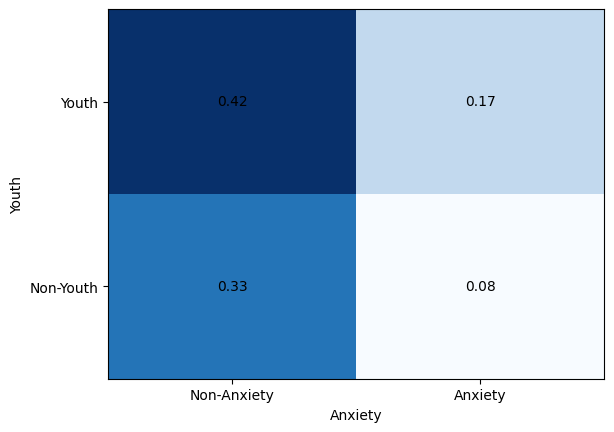

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.pcolor(df_pivot, cmap='Blues')
for i in range(df_pivot.shape[0]):
    for j in range(df_pivot.shape[1]):
        plt.text(j + 0.5, i + 0.5, f'{df_pivot[j][i]:.2f}',
                 ha='center', va='center', color='black')
plt.xticks([0.5, 1.5], ['Non-Anxiety', 'Anxiety'])
plt.yticks([0.5, 1.5], ['Non-Youth', 'Youth'])
plt.xlabel('Anxiety')
plt.ylabel('Youth')
plt.show()
plt.savefig('/content/drive/MyDrive/KHP_Data/anxiety_youth_heatmap.png', dpi=300, bbox_inches='tight')